# Transformer, Self-Attention и моделирование языка

In [ ]:
# Если Вы запускаете ноутбук на colab,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git
# import sys; sys.path.append('/content/stepik-dl-nlp')

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm

import dlnlputils
from dlnlputils.data import tokenize_corpus, build_vocabulary, \
    save_texts_to_file, LanguageModelDataset, load_war_and_piece_chunks, \
    GreedyGenerator, BeamGenerator
from dlnlputils.pipeline import train_eval_loop, init_random_seed
from dlnlputils.base import get_params_number

init_random_seed()

## Загрузка текстов и разбиение на обучающую и тестовую подвыборки

In [2]:
all_chunks = load_war_and_piece_chunks('./datasets/war_and_peace.txt')
len(all_chunks)

7976

In [3]:
print(all_chunks[10])

у нее был грипп, как она говорила (грипп был тогда новое
слово, употреблявшееся только редкими). В записочках, разосланных утром с
красным лакеем, было написано без различия во всех:
  "Si vous n'avez


In [4]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 5583
Размер валидационной выборки 2393


## Токенизация корпуса с помощью BPE

BPE - Byte Pair Encoding

YouTokenToMe - быстрая реализация BPE

In [5]:
BPE_MODEL_FILENAME = './models/war_and_peace_bpe.yttm'

In [6]:
TRAIN_TEXTS_FILENAME = './datasets/war_and_peace_bpe_train.txt'
save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME);

In [7]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [8]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л р в к , д м у п я г ь ы з б . ч й - ж ш e х ю s ц a n r i u o t щ э П l Н ф А В m d c О ? ! К Д Б p М v Р " ) С ( ' ; И Т ё 1 h : Я 2 q f Г ъ b g Ч Э 0 3 Е 5 ] [ j 4 I z Л З 6 8 M A 9 7 У Ж V L x X Ф Ш y C Х J B P D E N S k Ц R Q O T ` w Ю H U F G K Ь W Й * & # Щ Z / ▁с ▁п ▁в ▁н то ▁о ▁и ▁к го ал ра ст но ▁- ▁по ен ▁д ер ел ▁б ро ▁не ко во ка ▁ч ▁м ри ▁на ло ть на ли ла ▁з ▁е ▁у ▁т ре ва ни ся сь ак ▁что ру ет ▁ко ▁бы ми ны ня да ▁то ди хо ▁за ▁го ем ▁г ▁он ол ени ▁от ки ви ну каз е, ▁э та ▁П ти ши ▁при ▁вы ▁ра му ▁Н ▁ж ов ▁вс ле ▁А до ▁В ▁про ▁мо ля ▁как мо ▁во казал ры ▁его ма ▁об сто ▁это ль й, ▁сказал ере не ▁а ▁до ▁О ▁я ▁К ▁кото ▁сво ▁кня ▁Д м, у, ше ▁Б али по чи ▁но сти ▁ни си ча ста ель ▁из ве лу ала де ▁Ан вори ▁М ▁под ▁ка ▁d .. ша ... за ска жи ще es я, лся ▁со че лы зь сть ско ou ▁ли ▁хо ▁ви ▁ст ень ▁ру ря енно ▁Пь ▁так ме ты ▁p ▁Р ги га дел лю сно re же ▁раз ▁( со те ду ку ▁се ски ▁c ▁С ▁ва вши ▁все тель бе en вал ▁l ▁дру ▁было ▁И on

In [9]:
print(tokenizer.encode(train_texts[:1]))

[[210, 238, 244, 13, 317, 16, 147, 200, 12, 265, 35, 161, 337, 490, 203, 269, 447, 4, 111, 111, 96, 27, 415, 148, 176, 551, 201, 726, 199, 161, 848, 889, 772, 23, 16, 690, 179, 585, 18, 154, 412, 19, 382, 157, 186, 635, 10, 518, 774, 363, 670, 157, 793, 37, 7, 426, 791, 186, 635, 10, 518, 774, 650, 25, 988, 206, 186, 13, 201, 8, 149, 474, 17, 275, 31, 23, 8, 34, 444]]


In [10]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

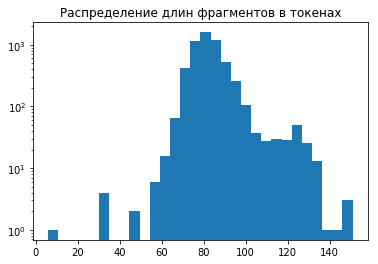

In [11]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

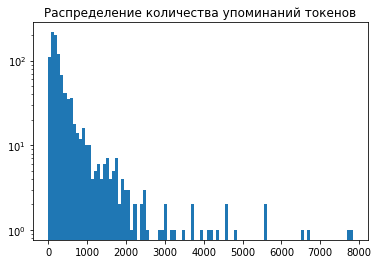

In [12]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [13]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


## Подготовка датасетов для PyTorch

In [14]:
CHUNK_LENGTH = 80

train_dataset = LanguageModelDataset(train_token_ids,
                                     chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids,
                                    chunk_length=CHUNK_LENGTH)

In [15]:
train_dataset[0]

(array([  2, 210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161,
        337, 490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176,
        551, 201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,
         18, 154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670,
        157, 793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25,
        988, 206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,
         34, 444]),
 array([210, 238, 244,  13, 317,  16, 147, 200,  12, 265,  35, 161, 337,
        490, 203, 269, 447,   4, 111, 111,  96,  27, 415, 148, 176, 551,
        201, 726, 199, 161, 848, 889, 772,  23,  16, 690, 179, 585,  18,
        154, 412,  19, 382, 157, 186, 635,  10, 518, 774, 363, 670, 157,
        793,  37,   7, 426, 791, 186, 635,  10, 518, 774, 650,  25, 988,
        206, 186,  13, 201,   8, 149, 474,  17, 275,  31,  23,   8,  34,
        444,   3]))

In [16]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш',
 'от восторга, с толпою побежал за ним. XXI. На площади куда поехал государь, стояли лицом к лицу справа батальон преображенцев, слева батальон французской гвардии в медвежьих ш<EOS>']

## Общие классы и функции

### Маска зависимостей

In [17]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask

make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Кодирование позиции

In [18]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

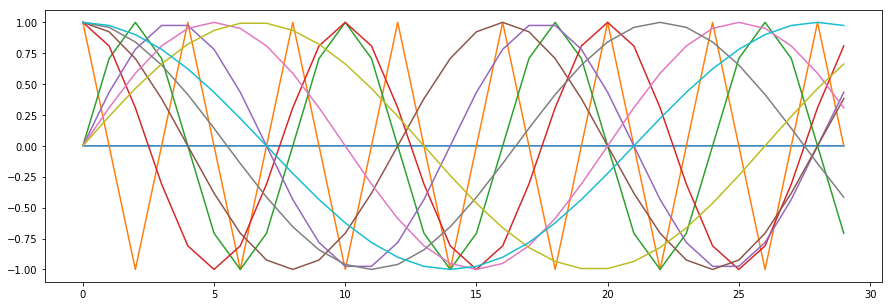

In [19]:
sample_pos_codes = make_positional_encoding(30, 30)
plt.plot(sample_pos_codes[:, ::3].numpy());
plt.gcf().set_size_inches((15, 5))

### Основной класс - языковая модель

In [20]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        """
            seed_token_ids - BatchSize x MaxInLen
        """
        batch_size, max_in_length = seed_token_ids.shape

        seed_padding_mask = seed_token_ids == 0
        dependency_mask = make_target_dependency_mask(max_in_length) \
            .to(seed_token_ids.device)
        
        seed_embs = self.embeddings(seed_token_ids)  # BatchSize x MaxInLen x EmbSize
        pos_codes = make_positional_encoding(max_in_length,
                                             self.embedding_size).unsqueeze(0).to(seed_embs.device)
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        # BatchSize x TargetLen x EmbSize
        target_features = seed_embs
        target_features = self.backbone(seed_embs,
                                        mask=dependency_mask,
                                        src_key_padding_mask=seed_padding_mask)
        logits = self.out(target_features)  # BatchSize x TargetLen x VocabSize
        return logits

### Утилиты для обучения - функция потерь и расписание изменения длины градиентного шага

In [21]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=20,
                                                      factor=0.5,
                                                      verbose=True)

## Реализация Transformer из PyTorch 1.2

In [22]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

In [23]:
torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256,
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=256,
                                           nhead=16,
                                           dim_feedforward=512,
                                           dropout=0.1),
                                       num_layers=3),
                                   emb_dropout=0.1)
print('Количество параметров', get_params_number(torch_transf_model))

Количество параметров 2094312


In [25]:
(best_val_loss,
 best_torch_transf_model) = train_eval_loop(torch_transf_model,
                                            train_dataset,
                                            test_dataset,
                                            lm_cross_entropy,
                                            lr=2e-3,
                                            epoch_n=2000,
                                            batch_size=512,
                                            device='cuda',
                                            early_stopping_patience=50,
                                            max_batches_per_epoch_train=1000,
                                            max_batches_per_epoch_val=1000,
                                            lr_scheduler_ctor=lr_scheduler)

In [25]:
torch.save(best_torch_transf_model.state_dict(), './models/war_and_peace_torch_transf_best.pth')

In [26]:
torch_transf_model.load_state_dict(torch.load('./models/war_and_peace_torch_transf_best.pth'))

<All keys matched successfully>

## Генерация текста с помощью языковой модели

### Жадная генерация

In [27]:
greedy_generator = GreedyGenerator(torch_transf_model, tokenizer)

In [28]:
%%time

print(greedy_generator('сказала княжна, оглядывая Бона'))

сказала княжна, оглядывая Бонапарте. - Ah! chere amie, - сказал он ему, - cousin ne m'a parlez pas de cela 
CPU times: user 3.02 s, sys: 47.5 ms, total: 3.07 s
Wall time: 1.45 s


In [29]:
print(greedy_generator('смеялась княжна, оглядывая Наполе'))

смеялась княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe de


In [30]:
print(greedy_generator('сказала княжна, оглядывая Кутуз'))

сказала княжна, оглядывая Кутузку и сел портретом и пока ноге робко взглядываясь на нее значение на Пьера, тотчас же щеголе


In [31]:
print(greedy_generator('сказал Кутузов, оглядывая Наполеона'))

сказал Кутузов, оглядывая Наполеона и отворяясь, показывавшиеся четыре гостей, около рта. - Кто там? - спросил кто-то удивл


### Генерация с помощью лучевого поиска - Beam Search

In [32]:
beam_generator = BeamGenerator(torch_transf_model, tokenizer)

In [33]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=5,
                                   return_hypotheses_n=5)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
0.8626641229794534
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe, la

****
0.867215443138969
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe de

****
0.9491151991653383
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe.

****
0.9805023955786255
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe 

****
1.1298425040190347
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe, a

CPU times: user 16.5 s, sys: 150 ms, total: 16.6 s
Wall time: 8.36 s


In [34]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=20,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
0.8626641229794534
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe, la

****
0.867215443138969
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe de

****
0.9491151991653383
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe.

****
0.9805023955786255
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe 

****
1.1298425040190347
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe, a

****
1.1368209431731167
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe, 

****
1.1653579336677458
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe;

****
1.1720160567731

In [35]:
%%time

beam_gen_variants = beam_generator('сказала княжна, оглядывая Наполе',
                                   beamsize=100,
                                   return_hypotheses_n=20)

for score, pred_txt in beam_gen_variants:
    print('****')
    print(score)
    print(pred_txt)
    print()

****
0.8626641229794534
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe, la

****
0.867215443138969
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe de

****
0.9491151991653383
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe.

****
0.9805023955786255
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe 

****
1.1298425040190347
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe, a

****
1.1368209431731167
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe, 

****
1.1653579336677458
сказала княжна, оглядывая Наполеоном, Анна Павловна собрала у себя вечер. La creme de la veritable bonne societe;

****
1.1712882987105

## Собственная реализация MultiHeadAttention

In [36]:
def my_multihead_attention(queries, keys, values,
                           keys_padding_mask, dependency_mask,
                           is_training,
                           weights_dropout):
    """
    queries - BatchSize x ValuesLen x HeadN x KeySize
    keys - BatchSize x KeysLen x HeadN x KeySize
    values - BatchSize x KeysLen x HeadN x ValueSize
    keys_padding_mask - BatchSize x KeysLen
    dependency_mask - ValuesLen x KeysLen
    is_training - bool
    weights_dropout - float
    
    result - tuple of two:
        - BatchSize x ValuesLen x HeadN x ValueSize - resulting features
        - BatchSize x ValuesLen x KeysLen x HeadN - attention map
    """

    # BatchSize x ValuesLen x KeysLen x HeadN
    relevances = torch.einsum('bvhs,bkhs->bvkh', (queries, keys))
    
    # замаскировать элементы, выходящие за длины последовательностей ключей
    padding_mask_expanded = keys_padding_mask[:, None, :, None].expand_as(relevances)
    relevances.masked_fill_(padding_mask_expanded, float('-inf'))
    
    # замаскировать пары <выходная позиция, входная позиция>
    relevances = relevances + dependency_mask[None, :, :, None].expand_as(relevances)
    
    normed_rels = F.softmax(relevances, dim=2)    
    normed_rels = F.dropout(normed_rels, weights_dropout, is_training)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x 1
    normed_rels_expanded = normed_rels.unsqueeze(-1)
    
    # BatchSize x 1 x KeysLen x HeadN x ValueSize
    values_expanded = values.unsqueeze(1)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x ValueSize
    weighted_values = normed_rels_expanded * values_expanded
    result = weighted_values.sum(2)  # BatchSize x ValuesLen x HeadN x ValueSize
    
    return result, normed_rels

## Self-Attention - это Attention, в котором ключи, значения и запросы вычисляются из элементов одной и той же последовательности

In [37]:
class MyMultiheadSelfAttention(nn.Module):
    def __init__(self, model_size, n_heads, dropout=0):
        super().__init__()
        assert model_size % n_heads == 0, 'Размерность модели должна делиться нацело на количество голов'
        self.n_heads = n_heads

        self.queries_proj = nn.Linear(model_size, model_size)
        self.keys_proj = nn.Linear(model_size, model_size)
        self.values_proj = nn.Linear(model_size, model_size)
        
        self.dropout = dropout

        self.last_attention_map = None
    
    def forward(self, sequence, padding_mask, dependency_mask):
        """
        sequence - BatchSize x Len x ModelSize
        padding_mask - BatchSize x Len
        dependency_mask - Len x Len
        
        result - BatchSize x Len x ModelSize
        """
        batch_size, max_len, model_size = sequence.shape
        
        queries_flat = self.queries_proj(sequence)  # BatchSize x Len x ModelSize
        queries = queries_flat.view(batch_size, max_len, self.n_heads, -1)
        
        keys_flat = self.keys_proj(sequence)  # BatchSize x Len x ModelSize
        keys = keys_flat.view(batch_size, max_len, self.n_heads, -1)
        
        values_flat = self.values_proj(sequence)  # BatchSize x Len x ModelSize
        values = values_flat.view(batch_size, max_len, self.n_heads, -1)
        
        # BatchSize x Len x HeadsN x ValueSize
        result, att_map = my_multihead_attention(queries, keys, values,
                                                 padding_mask, dependency_mask,
                                                 self.training, self.dropout)
        result_flat = result.view(batch_size, max_len, model_size)
        
        self.last_attention_map = att_map.detach()

        return result_flat

## Один слой трансформера - Self-Attention, Feed-Forward, skip-connections, LayerNorm

In [38]:
class MyTransformerEncoderLayer(nn.Module):
    def __init__(self, model_size, n_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = MyMultiheadSelfAttention(model_size,
                                                       n_heads,
                                                       dropout=dropout)
        self.first_dropout = nn.Dropout(dropout)
        self.first_norm = nn.LayerNorm(model_size)
        
        self.feedforward = nn.Sequential(
            nn.Linear(model_size, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, model_size),
            nn.Dropout(dropout)
        )
        self.second_norm = nn.LayerNorm(model_size)
    
    def forward(self, sequence, padding_mask, dependency_mask):
        att_features = self.self_attention(sequence, padding_mask, dependency_mask)

        sequence = sequence + self.first_dropout(att_features)
        sequence = self.first_norm(sequence)
        
        sequence = sequence + self.feedforward(sequence)
        sequence = self.second_norm(sequence)
        return sequence

## Энкодер Трансформера - стопка из нескольких слоёв

In [39]:
class MyTransformerEncoder(nn.Module):
    def __init__(self, n_layers, **layer_kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            MyTransformerEncoderLayer(**layer_kwargs)
            for _ in range(n_layers)
        ])
        self.initialize_weights()

    def forward(self, sequence, mask, src_key_padding_mask):
        for layer in self.layers:
            sequence = layer(sequence, src_key_padding_mask, mask)
        return sequence

    def initialize_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

## Попробуем обучить языковую модель с нашим Трансформером

In [40]:
my_transf_model = LanguageModel(tokenizer.vocab_size(),
                                256,
                                MyTransformerEncoder(
                                    n_layers=3,
                                    model_size=256,
                                    n_heads=16,
                                    dim_feedforward=512,
                                    dropout=0.1),
                                emb_dropout=0.1)
print('Количество параметров', get_params_number(my_transf_model))

Количество параметров 1896936


In [41]:
(best_val_loss,
 best_my_transf_model) = train_eval_loop(my_transf_model,
                                         train_dataset,
                                         test_dataset,
                                         lm_cross_entropy,
                                         lr=2e-3,
                                         epoch_n=2000,
                                         batch_size=512,
                                         device='cuda',
                                         early_stopping_patience=50,
                                         max_batches_per_epoch_train=1000,
                                         max_batches_per_epoch_val=1000,
                                         lr_scheduler_ctor=lr_scheduler)

Эпоха 0
Эпоха: 11 итераций, 6.02 сек
Среднее значение функции потерь на обучении 6.404186725616455
Среднее значение функции потерь на валидации 6.248231697082519
Новая лучшая модель!

Эпоха 1
Эпоха: 11 итераций, 6.01 сек
Среднее значение функции потерь на обучении 6.2512031901966445
Среднее значение функции потерь на валидации 6.239421558380127
Новая лучшая модель!

Эпоха 2
Эпоха: 11 итераций, 6.01 сек
Среднее значение функции потерь на обучении 6.241438735615123
Среднее значение функции потерь на валидации 6.232439422607422
Новая лучшая модель!

Эпоха 3
Эпоха: 11 итераций, 6.03 сек
Среднее значение функции потерь на обучении 6.229505322196267
Среднее значение функции потерь на валидации 6.216948127746582
Новая лучшая модель!

Эпоха 4
Эпоха: 11 итераций, 6.01 сек
Среднее значение функции потерь на обучении 6.198947906494141
Среднее значение функции потерь на валидации 6.114001083374023
Новая лучшая модель!

Эпоха 5
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучени

Среднее значение функции потерь на валидации 3.4038021087646486
Новая лучшая модель!

Эпоха 45
Эпоха: 11 итераций, 6.01 сек
Среднее значение функции потерь на обучении 3.16250298239968
Среднее значение функции потерь на валидации 3.3937983989715574
Новая лучшая модель!

Эпоха 46
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 3.140316703102805
Среднее значение функции потерь на валидации 3.3763250350952148
Новая лучшая модель!

Эпоха 47
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 3.118376861919056
Среднее значение функции потерь на валидации 3.3723618507385256
Новая лучшая модель!

Эпоха 48
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 3.100417982448231
Среднее значение функции потерь на валидации 3.3633368015289307
Новая лучшая модель!

Эпоха 49
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 3.080427494916049
Среднее значение функции потерь на валидации 3.3555209636688232
Новая л

Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 2.6126320362091064
Среднее значение функции потерь на валидации 3.1601587295532227

Эпоха 90
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 2.600582621314309
Среднее значение функции потерь на валидации 3.158857297897339

Эпоха 91
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.5937611189755527
Среднее значение функции потерь на валидации 3.152006816864014
Новая лучшая модель!

Эпоха 92
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.5875672210346568
Среднее значение функции потерь на валидации 3.145660161972046
Новая лучшая модель!

Эпоха 93
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.579135526310314
Среднее значение функции потерь на валидации 3.1450501918792724
Новая лучшая модель!

Эпоха 94
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.5747249126434326
Среднее значение фун

Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.357367927377874
Среднее значение функции потерь на валидации 3.0500585079193114
Новая лучшая модель!

Эпоха 136
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.3559456088326196
Среднее значение функции потерь на валидации 3.050859069824219

Эпоха 137
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.3514586578715932
Среднее значение функции потерь на валидации 3.050319957733154

Эпоха 138
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.3456830111416904
Среднее значение функции потерь на валидации 3.0446784496307373
Новая лучшая модель!

Эпоха 139
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.343312003395774
Среднее значение функции потерь на валидации 3.045094203948975

Эпоха 140
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.339918786829168
Среднее значение функции потерь на ва

Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.2149373184550893
Среднее значение функции потерь на валидации 2.985824632644653
Новая лучшая модель!

Эпоха 183
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.211141889745539
Среднее значение функции потерь на валидации 2.9861413478851317

Эпоха 184
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.207796747034246
Среднее значение функции потерь на валидации 2.9843371868133546
Новая лучшая модель!

Эпоха 185
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.20668643171137
Среднее значение функции потерь на валидации 2.9781441688537598
Новая лучшая модель!

Эпоха 186
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.2043818560513584
Среднее значение функции потерь на валидации 2.9906548976898195

Эпоха 187
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.2028685916553843
Среднее значени

Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.1183877858248623
Среднее значение функции потерь на валидации 2.9405829906463623

Эпоха 230
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 2.1205406839197334
Среднее значение функции потерь на валидации 2.9400185108184815

Эпоха 231
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.1136046322909268
Среднее значение функции потерь на валидации 2.9388433933258056

Эпоха 232
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.1205350052226675
Среднее значение функции потерь на валидации 2.937972068786621
Новая лучшая модель!

Эпоха 233
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.1139575351368296
Среднее значение функции потерь на валидации 2.927508735656738
Новая лучшая модель!

Эпоха 234
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.115530100735751
Среднее значение функции потерь на

Среднее значение функции потерь на валидации 2.905499076843262

Эпоха 278
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.052264170213179
Среднее значение функции потерь на валидации 2.911037540435791

Эпоха 279
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.050556247884577
Среднее значение функции потерь на валидации 2.911716032028198

Эпоха 280
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.050756736235185
Среднее значение функции потерь на валидации 2.909127712249756

Эпоха 281
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 2.0474670150063257
Среднее значение функции потерь на валидации 2.908279275894165

Эпоха 282
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.045125040141019
Среднее значение функции потерь на валидации 2.901356267929077
Новая лучшая модель!

Эпоха 283
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 2.0460

Среднее значение функции потерь на валидации 2.8810867786407472
Новая лучшая модель!

Эпоха 326
Эпоха: 11 итераций, 6.01 сек
Среднее значение функции потерь на обучении 1.9974431666460903
Среднее значение функции потерь на валидации 2.8827534198760985

Эпоха 327
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.994190519506281
Среднее значение функции потерь на валидации 2.8819057941436768

Эпоха 328
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.9919589974663474
Среднее значение функции потерь на валидации 2.880541515350342
Новая лучшая модель!

Эпоха 329
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.9915269830010154
Среднее значение функции потерь на валидации 2.881486749649048

Эпоха 330
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.9928387728604404
Среднее значение функции потерь на валидации 2.8811153888702394

Эпоха 331
Эпоха: 11 итераций, 5.99 сек
Среднее значение функц

Среднее значение функции потерь на валидации 2.85265851020813
Новая лучшая модель!

Эпоха 374
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.959489486434243
Среднее значение функции потерь на валидации 2.858908987045288

Эпоха 375
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.9531361948360095
Среднее значение функции потерь на валидации 2.8588443279266356

Эпоха 376
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.9552963213487105
Среднее значение функции потерь на валидации 2.855342435836792

Эпоха 377
Эпоха: 11 итераций, 6.05 сек
Среднее значение функции потерь на обучении 1.95062564719807
Среднее значение функции потерь на валидации 2.8647154808044433

Эпоха 378
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.9525782628492876
Среднее значение функции потерь на валидации 2.8583147525787354

Эпоха 379
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.9

Среднее значение функции потерь на валидации 2.8431958675384523
Новая лучшая модель!

Эпоха 423
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.9154698631980203
Среднее значение функции потерь на валидации 2.8551228523254393

Эпоха 424
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.9193836125460537
Среднее значение функции потерь на валидации 2.84828462600708

Эпоха 425
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.9223713224584407
Среднее значение функции потерь на валидации 2.8455106258392333

Эпоха 426
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.923463517969305
Среднее значение функции потерь на валидации 2.844959926605225

Эпоха 427
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.9200592907992275
Среднее значение функции потерь на валидации 2.845846080780029

Эпоха 428
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1

Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.8898250731554898
Среднее значение функции потерь на валидации 2.834614562988281

Эпоха 472
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.8909573771736838
Среднее значение функции потерь на валидации 2.83068790435791

Эпоха 473
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.8875029412182895
Среднее значение функции потерь на валидации 2.831146574020386

Эпоха 474
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.8884163769808682
Среднее значение функции потерь на валидации 2.833163261413574

Эпоха 475
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.8898286711085925
Среднее значение функции потерь на валидации 2.833782768249512

Эпоха 476
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.8887272531336003
Среднее значение функции потерь на валидации 2.8294068813323974

Эпоха 477
Эпох

Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.867739363150163
Среднее значение функции потерь на валидации 2.823687267303467

Эпоха 521
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.8656873377886685
Среднее значение функции потерь на валидации 2.8269632339477537

Эпоха 522
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.868723284114491
Среднее значение функции потерь на валидации 2.820727825164795

Эпоха 523
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.8652209043502808
Среднее значение функции потерь на валидации 2.822832775115967

Эпоха 524
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.8655934117057107
Среднее значение функции потерь на валидации 2.8212607383728026

Эпоха 525
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.8637685559012673
Среднее значение функции потерь на валидации 2.8227554321289063

Эпоха 526
Эпо

Среднее значение функции потерь на валидации 2.785499620437622

Эпоха 569
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.768710970878601
Среднее значение функции потерь на валидации 2.777035140991211
Новая лучшая модель!

Эпоха 570
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.7692611759359187
Среднее значение функции потерь на валидации 2.781027364730835

Эпоха 571
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.7691798426888206
Среднее значение функции потерь на валидации 2.7821092128753664

Эпоха 572
Эпоха: 11 итераций, 6.01 сек
Среднее значение функции потерь на обучении 1.7646569555455989
Среднее значение функции потерь на валидации 2.784104251861572

Эпоха 573
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.7667910944331775
Среднее значение функции потерь на валидации 2.7757755279541017
Новая лучшая модель!

Эпоха 574
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции

Среднее значение функции потерь на валидации 2.7720129013061525

Эпоха 617
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.7441701022061435
Среднее значение функции потерь на валидации 2.7607137680053713
Новая лучшая модель!

Эпоха 618
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.7476949366656216
Среднее значение функции потерь на валидации 2.770432138442993

Эпоха 619
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.7469738071615046
Среднее значение функции потерь на валидации 2.765931272506714

Эпоха 620
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.7466447678479282
Среднее значение функции потерь на валидации 2.7627213478088377

Эпоха 621
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.741192958571694
Среднее значение функции потерь на валидации 2.7677986145019533

Эпоха 622
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении

Среднее значение функции потерь на валидации 2.751256227493286

Эпоха 665
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6956995617259631
Среднее значение функции потерь на валидации 2.7507072925567626

Эпоха 666
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6947397860613735
Среднее значение функции потерь на валидации 2.7524134159088134

Эпоха 667
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.69334754076871
Среднее значение функции потерь на валидации 2.750582695007324

Эпоха 668
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.6935053955424915
Среднее значение функции потерь на валидации 2.753421258926392

Эпоха 669
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.6977173415097324
Среднее значение функции потерь на валидации 2.753197765350342

Эпоха 670
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.6931377432563088
Сред

Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.683306954123757
Среднее значение функции потерь на валидации 2.7439382553100584

Эпоха 714
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6846010793339123
Среднее значение функции потерь на валидации 2.745016860961914

Эпоха 715
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.6871002153916792
Среднее значение функции потерь на валидации 2.7457653045654298

Эпоха 716
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6857339252125134
Среднее значение функции потерь на валидации 2.7455458641052246

Эпоха 717
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.6804501468485051
Среднее значение функции потерь на валидации 2.739273500442505
Новая лучшая модель!

Эпоха 718
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.6838006214662031
Среднее значение функции потерь на валидации 2.74417815

Среднее значение функции потерь на валидации 2.7354049682617188

Эпоха 762
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.6592594385147095
Среднее значение функции потерь на валидации 2.733359146118164

Эпоха 763
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.660107504237782
Среднее значение функции потерь на валидации 2.7361403942108153

Эпоха 764
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.6584920449690386
Среднее значение функции потерь на валидации 2.736423206329346

Эпоха 765
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.661582892591303
Среднее значение функции потерь на валидации 2.735336494445801

Эпоха 766
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.655117923563177
Среднее значение функции потерь на валидации 2.7357367515563964

Эпоха 767
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6605279012159868
Сред

Среднее значение функции потерь на валидации 2.7281236171722414

Эпоха 811
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.645031300458041
Среднее значение функции потерь на валидации 2.7289578914642334

Эпоха 812
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6496496417305686
Среднее значение функции потерь на валидации 2.730484437942505

Эпоха 813
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.6480175256729126
Среднее значение функции потерь на валидации 2.728407859802246

Эпоха 814
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6478199308568782
Среднее значение функции потерь на валидации 2.7297204971313476

Эпоха 815
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.6487241116437046
Среднее значение функции потерь на валидации 2.731821632385254

Эпоха 816
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6471965312957764
Ср

Среднее значение функции потерь на валидации 2.7276575565338135

Эпоха 860
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.642483418638056
Среднее значение функции потерь на валидации 2.7267431259155273

Эпоха 861
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.637695388360457
Среднее значение функции потерь на валидации 2.7262192726135255

Эпоха 862
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.638239567930048
Среднее значение функции потерь на валидации 2.7264869689941404

Эпоха 863
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.6333169720389626
Среднее значение функции потерь на валидации 2.725054979324341

Эпоха 864
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.6401921077208086
Среднее значение функции потерь на валидации 2.7266427516937255

Эпоха 865
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6387188759717075
Ср

Среднее значение функции потерь на валидации 2.725998544692993
Epoch   908: reducing learning rate of group 0 to 1.5625e-05.

Эпоха 909
Эпоха: 11 итераций, 5.98 сек
Среднее значение функции потерь на обучении 1.6317720304835925
Среднее значение функции потерь на валидации 2.726247692108154

Эпоха 910
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6335790265690198
Среднее значение функции потерь на валидации 2.7259685039520263

Эпоха 911
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.6333734664050015
Среднее значение функции потерь на валидации 2.7259605884552003

Эпоха 912
Эпоха: 11 итераций, 6.00 сек
Среднее значение функции потерь на обучении 1.6351265907287598
Среднее значение функции потерь на валидации 2.726278877258301

Эпоха 913
Эпоха: 11 итераций, 5.99 сек
Среднее значение функции потерь на обучении 1.6346579139882869
Среднее значение функции потерь на валидации 2.730538511276245

Эпоха 914
Эпоха: 11 итераций, 5.99 сек
Сре

In [42]:
torch.save(best_my_transf_model.state_dict(), './models/war_and_peace_my_transf_best.pth')

In [43]:
my_transf_model.load_state_dict(torch.load('./models/war_and_peace_my_transf_best.pth'))

<All keys matched successfully>

## Наша реализация - жадная генерация

In [44]:
my_greedy_generator = GreedyGenerator(my_transf_model, tokenizer)

In [45]:
my_greedy_generator('сказала княжна, оглядывая Андре')

"сказала княжна, оглядывая Андрея. - Ах, как! Господа, - сказала она с Лизой, - не г'афиня, - сказала она, сквозь слезы что-то злоб"

## Визуализация карт внимания

In [46]:
def plot_attention_maps(model, input_string, tokenizer, device='cuda', max_heads=2, figsize=(16, 10)):
    device = torch.device(device)

    token_ids = tokenizer.encode([input_string])[0]

    token_strs = [tokenizer.id_to_subword(i) for i in token_ids]
    in_len = len(token_ids)
    ticks = np.arange(0, in_len)

    model.to(device)
    model.eval()

    in_batch = torch.tensor(token_ids).unsqueeze(0).to(device)
    model(in_batch)

    for module in model.modules():
        if isinstance(module, MyMultiheadSelfAttention):
            cur_last_attention_map = module.last_attention_map[0].cpu().numpy()
            n_heads = cur_last_attention_map.shape[-1]
            n_heads_to_vis = min(n_heads, max_heads)

            fig, axes = plt.subplots(1, n_heads_to_vis)
            fig.set_size_inches(figsize)
            for head_i in range(n_heads_to_vis):
                ax = axes[head_i]
                ax.imshow(cur_last_attention_map[..., head_i])

                ax.set_yticks(ticks)
                ax.set_ylim(bottom=in_len - 0.5, top=-0.5)
                ax.set_yticklabels(token_strs)

                ax.set_xticks(ticks)
                ax.set_xticklabels(token_strs)

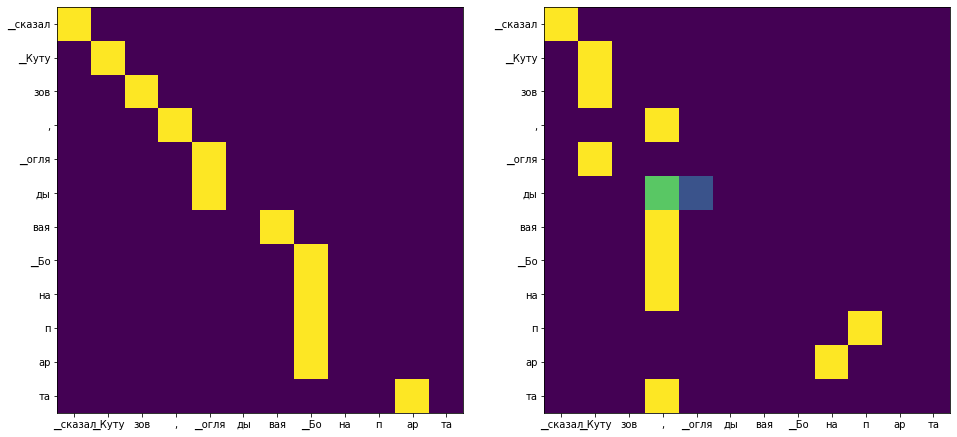

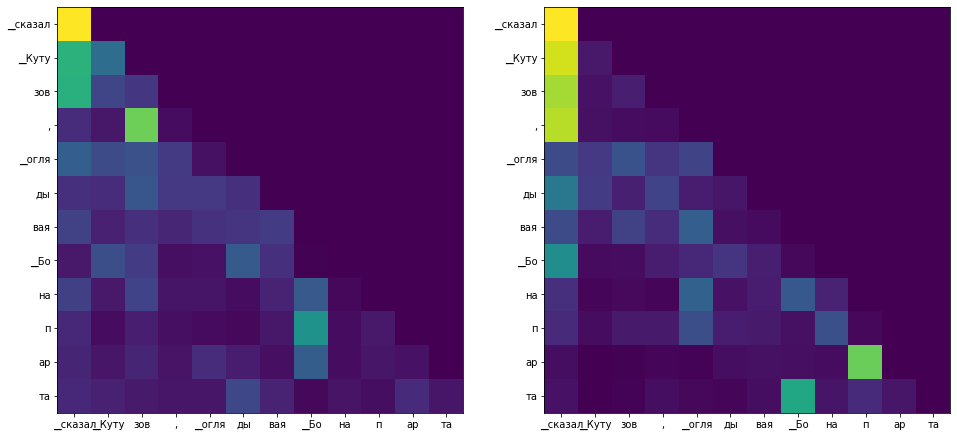

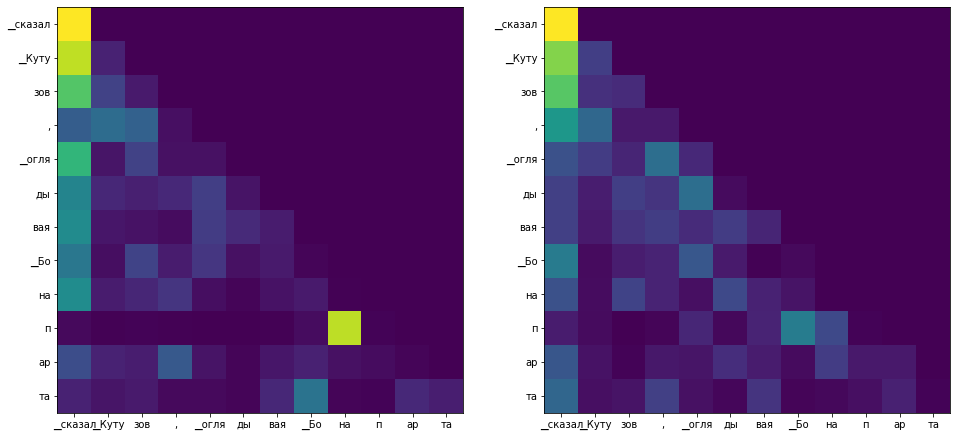

In [47]:
plot_attention_maps(my_transf_model, 'сказал Кутузов, оглядывая Бонапарта', tokenizer)